In [81]:
!pip install git+https://github.com/baidu/AdvBox.git 

  Cloning https://github.com/baidu/AdvBox.git to /tmp/pip-req-build-ylqgdmye
  Running command git clone -q https://github.com/baidu/AdvBox.git /tmp/pip-req-build-ylqgdmye


In [82]:
!pip install -r requirements.txt

  Using cached absl-py-0.4.1.tar.gz (88 kB)
  Using cached astor-0.7.1-py2.py3-none-any.whl (27 kB)
  Using cached backports.functools_lru_cache-1.5-py2.py3-none-any.whl (7.0 kB)
  Using cached backports.weakref-1.0.post1-py2.py3-none-any.whl (5.2 kB)
  Using cached certifi-2018.8.24-py2.py3-none-any.whl (147 kB)
  Using cached enum34-1.1.6-py3-none-any.whl (12 kB)
  Using cached funcsigs-1.0.2-py2.py3-none-any.whl (17 kB)
ERROR: Could not find a version that satisfies the requirement futures==3.2.0 (from versions: 0.2.python3, 0.1, 0.2, 1.0, 2.0, 2.1, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 3.0.0, 3.0.1, 3.0.2, 3.0.3, 3.0.4, 3.0.5, 3.1.0, 3.1.1)
ERROR: No matching distribution found for futures==3.2.0


In [83]:
import logging
logging.basicConfig(level=logging.INFO,format="%(filename)s[line:%(lineno)d] %(levelname)s %(message)s")
logger=logging.getLogger(__name__)

import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
from adversarialbox.adversary import Adversary
from adversarialbox.attacks.deepfool import DeepFoolAttack
from adversarialbox.attacks.gradient_method import FGSMT
from adversarialbox.models.pytorch import PytorchModel
import numpy as np
import cv2
import tensorflow
import matplotlib.pyplot as plt
from past.utils import old_div
#from tools import show_images_diff

In [84]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [85]:
import sys
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-2gqp_tr2
  Running command git clone -q https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-2gqp_tr2


In [86]:
def show_images_diff(original_img, original_label, adversarial_img, adversarial_label):
    plt.figure()

    plt.subplot(131)
    plt.title('Original')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(132)
    plt.title('Adversarial')
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(133)
    plt.title('Adversarial-Original')
    difference = adversarial_img - original_img

    l0 = np.where(difference != 0)[0].shape[0]
    l2 = np.linalg.norm(difference)
    # print(difference)
    print("l0={} l2={}".format(l0, l2))

    # (-1,1)  -> (0,1)
    difference = old_div(difference, abs(difference).max()) / 2.0 + 0.5

    plt.imshow(difference, cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [87]:
result = True
image_path = tensorflow.keras.utils.get_file('Panda', origin= 'https://pbs.twimg.com/profile_images/829274786362699776/a1ttXfVG.jpg')

In [88]:
# Define what device we are using
logging.info("CUDA Available: {}".format(torch.cuda.is_available()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# bgr -> rgb   
orig = cv2.imread(image_path)[..., ::-1]

orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std

 
#[224,224,3]->[3,224,224]
img = img.transpose(2, 0, 1)

img = Variable(torch.from_numpy(img).to(device).float().unsqueeze(0)).cpu().numpy()


# Initialize the network

model = models.resnet50(pretrained=True).to(device).eval()

#print(model)


for param in model.parameters():
    param.requires_grad = False

# advbox demo
m = PytorchModel(
    model, None,(-3, 3),
    channel_axis=1)

attack = DeepFoolAttack(m)
attack_config = {"iterations": 100, "overshoot": 0.02}

inputs=img
labels = None

print(inputs.shape)

adversary = Adversary(inputs, labels)

tlabel = 538
adversary.set_target(is_targeted_attack=True, target_label=tlabel)


adversary = attack(adversary, **attack_config)


if adversary.is_successful():
    print(
        'attack success, adversarial_label=%d'
        % (adversary.adversarial_label))

    adv=adversary.adversarial_example[0]

else:
    result = False
    print('attack failed')


print("Deepfool attack done")

<ipython-input-88-0efe2dd515ed>[line:2] INFO CUDA Available: False
pytorch.py[line:53] INFO Finish PytorchModel init


cpu
(1, 3, 224, 224)


base.py[line:75] INFO adversary:
         original_label: 388
         target_label: 538
         is_targeted_attack: True
deepfool.py[line:41] INFO min_=-3, max_=3
deepfool.py[line:60] INFO select label:538
deepfool.py[line:108] INFO iteration=0, f[pre_label]=8.315276145935059, f[target_label]=-1.6099389791488647, f[adv_label]=8.315276145935059, pre_label=388, adv_label=388
deepfool.py[line:108] INFO iteration=1, f[pre_label]=5.207057952880859, f[target_label]=-0.6953913569450378, f[adv_label]=6.657176971435547, pre_label=388, adv_label=850
deepfool.py[line:108] INFO iteration=2, f[pre_label]=3.7263407707214355, f[target_label]=0.31164172291755676, f[adv_label]=6.072879314422607, pre_label=388, adv_label=850
deepfool.py[line:108] INFO iteration=3, f[pre_label]=2.5110361576080322, f[target_label]=1.2047088146209717, f[adv_label]=5.978833198547363, pre_label=388, adv_label=850
deepfool.py[line:108] INFO iteration=4, f[pre_label]=2.098513603210449, f[target_label]=1.6604492664337158, f[a

attack success, adversarial_label=538
Deepfool attack done


l0=76220 l2=55033.23539462313


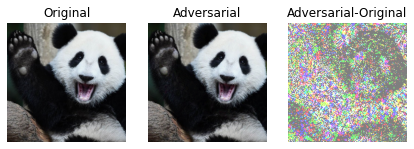

In [89]:
if result:
  adv = adv.transpose(1, 2, 0)
  adv = (adv * std) + mean
  adv = adv * 256.0
  adv = np.clip(adv, 0, 255).astype(np.uint8)
  show_images_diff(orig,adversary.original_label,adv,adversary.adversarial_label)

### Inception

In [90]:
# Define what device we are using
logging.info("CUDA Available: {}".format(torch.cuda.is_available()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# bgr -> rgb   
orig = cv2.imread(image_path)[..., ::-1]

orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std

 
#[224,224,3]->[3,224,224]
img = img.transpose(2, 0, 1)

img = Variable(torch.from_numpy(img).to(device).float().unsqueeze(0)).cpu().numpy()


# Initialize the network

model = models.inception_v3(pretrained=True).to(device).eval()

#print(model)


for param in model.parameters():
    param.requires_grad = False

# advbox demo
m = PytorchModel(
    model, None,(-3, 3),
    channel_axis=1)
attack = DeepFoolAttack(m)
attack_config = {"iterations": 100, "overshoot": 0.02}

inputs=img
labels = None

print(inputs.shape)

adversary = Adversary(inputs, labels)

tlabel = 538
adversary.set_target(is_targeted_attack=True, target_label=tlabel)


adversary = attack(adversary, **attack_config)


if adversary.is_successful():
    print(
        'attack success, adversarial_label=%d'
        % (adversary.adversarial_label))

    adv=adversary.adversarial_example[0]

else:
    result = False
    print('attack failed')


print("Deepfool attack done")

<ipython-input-90-a7ead3a9edc2>[line:2] INFO CUDA Available: False
pytorch.py[line:53] INFO Finish PytorchModel init
base.py[line:75] INFO adversary:
         original_label: 388
         target_label: 538
         is_targeted_attack: True
deepfool.py[line:41] INFO min_=-3, max_=3


cpu
(1, 3, 224, 224)


deepfool.py[line:60] INFO select label:538
deepfool.py[line:108] INFO iteration=0, f[pre_label]=12.250272750854492, f[target_label]=1.3741650581359863, f[adv_label]=13.78663444519043, pre_label=388, adv_label=850
deepfool.py[line:108] INFO iteration=1, f[pre_label]=6.584073066711426, f[target_label]=1.2934868335723877, f[adv_label]=15.048971176147461, pre_label=388, adv_label=850
deepfool.py[line:108] INFO iteration=2, f[pre_label]=4.430220127105713, f[target_label]=1.3086893558502197, f[adv_label]=15.061652183532715, pre_label=388, adv_label=850
deepfool.py[line:108] INFO iteration=3, f[pre_label]=3.877805471420288, f[target_label]=1.6113370656967163, f[adv_label]=15.788339614868164, pre_label=388, adv_label=850
deepfool.py[line:108] INFO iteration=4, f[pre_label]=3.066798448562622, f[target_label]=1.6200016736984253, f[adv_label]=15.686742782592773, pre_label=388, adv_label=850
deepfool.py[line:108] INFO iteration=5, f[pre_label]=2.8162527084350586, f[target_label]=1.9119560718536377

attack success, adversarial_label=538
Deepfool attack done


l0=95820 l2=59275.09919856735


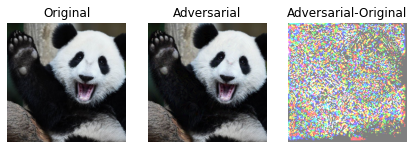

In [91]:
if result:
  adv = adv.transpose(1, 2, 0)
  adv = (adv * std) + mean
  adv = adv * 256.0
  adv = np.clip(adv, 0, 255).astype(np.uint8)
  show_images_diff(orig,adversary.original_label,adv,adversary.adversarial_label)

### Googlenet

In [92]:
# Define what device we are using
logging.info("CUDA Available: {}".format(torch.cuda.is_available()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# bgr -> rgb   
orig = cv2.imread(image_path)[..., ::-1]

orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std

 
#[224,224,3]->[3,224,224]
img = img.transpose(2, 0, 1)

img = Variable(torch.from_numpy(img).to(device).float().unsqueeze(0)).cpu().numpy()


# Initialize the network

model = models.googlenet(pretrained=True).to(device).eval()

#print(model)


for param in model.parameters():
    param.requires_grad = False

# advbox demo
m = PytorchModel(
    model, None,(-3, 3),
    channel_axis=1)
attack = DeepFoolAttack(m)
attack_config = {"iterations": 100, "overshoot": 0.02}

inputs=img
labels = None

print(inputs.shape)

adversary = Adversary(inputs, labels)

tlabel = 538
adversary.set_target(is_targeted_attack=True, target_label=tlabel)


adversary = attack(adversary, **attack_config)


if adversary.is_successful():
    print(
        'attack success, adversarial_label=%d'
        % (adversary.adversarial_label))

    adv=adversary.adversarial_example[0]

else:
    result = False
    print('attack failed')


print("Deepfool attack done")

<ipython-input-92-ff2fccece9f5>[line:2] INFO CUDA Available: False
pytorch.py[line:53] INFO Finish PytorchModel init
base.py[line:75] INFO adversary:
         original_label: 388
         target_label: 538
         is_targeted_attack: True
deepfool.py[line:41] INFO min_=-3, max_=3


cpu
(1, 3, 224, 224)


deepfool.py[line:60] INFO select label:538
deepfool.py[line:108] INFO iteration=0, f[pre_label]=5.544585704803467, f[target_label]=-0.025212839245796204, f[adv_label]=5.544585704803467, pre_label=388, adv_label=388
deepfool.py[line:108] INFO iteration=1, f[pre_label]=3.5741772651672363, f[target_label]=0.6190934181213379, f[adv_label]=3.5741772651672363, pre_label=388, adv_label=388
deepfool.py[line:108] INFO iteration=2, f[pre_label]=2.6469316482543945, f[target_label]=1.149737000465393, f[adv_label]=3.031383991241455, pre_label=388, adv_label=804
deepfool.py[line:108] INFO iteration=3, f[pre_label]=2.031277656555176, f[target_label]=1.3722293376922607, f[adv_label]=2.9229726791381836, pre_label=388, adv_label=804
deepfool.py[line:108] INFO iteration=4, f[pre_label]=1.7221367359161377, f[target_label]=1.5566145181655884, f[adv_label]=3.078752040863037, pre_label=388, adv_label=804
deepfool.py[line:108] INFO iteration=5, f[pre_label]=1.628251075744629, f[target_label]=1.623097538948059

attack success, adversarial_label=538
Deepfool attack done


l0=93894 l2=59873.943623249004


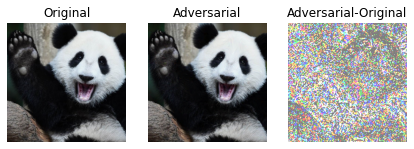

In [93]:
if result:
  adv = adv.transpose(1, 2, 0)
  adv = (adv * std) + mean
  adv = adv * 256.0
  adv = np.clip(adv, 0, 255).astype(np.uint8)
  show_images_diff(orig,adversary.original_label,adv,adversary.adversarial_label)

### Densenet

In [94]:
# Define what device we are using
logging.info("CUDA Available: {}".format(torch.cuda.is_available()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# bgr -> rgb   
orig = cv2.imread(image_path)[..., ::-1]

orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std

 
#[224,224,3]->[3,224,224]
img = img.transpose(2, 0, 1)

img = Variable(torch.from_numpy(img).to(device).float().unsqueeze(0)).cpu().numpy()


# Initialize the network

model = models.densenet121(pretrained=True).to(device).eval()

#print(model)


for param in model.parameters():
    param.requires_grad = False

# advbox demo
m = PytorchModel(
    model, None,(-3, 3),
    channel_axis=1)
attack = DeepFoolAttack(m)
attack_config = {"iterations": 100, "overshoot": 0.02}

inputs=img
labels = None

print(inputs.shape)

adversary = Adversary(inputs, labels)

tlabel = 538
adversary.set_target(is_targeted_attack=True, target_label=tlabel)


adversary = attack(adversary, **attack_config)


if adversary.is_successful():
    print(
        'attack success, adversarial_label=%d'
        % (adversary.adversarial_label))

    adv=adversary.adversarial_example[0]

else:
    result = False
    print('attack failed')


print("Deepfool attack done")

<ipython-input-94-cd91dab72f91>[line:2] INFO CUDA Available: False
pytorch.py[line:53] INFO Finish PytorchModel init
base.py[line:75] INFO adversary:
         original_label: 388
         target_label: 538
         is_targeted_attack: True
deepfool.py[line:41] INFO min_=-3, max_=3


cpu
(1, 3, 224, 224)


deepfool.py[line:60] INFO select label:538
deepfool.py[line:108] INFO iteration=0, f[pre_label]=8.224408149719238, f[target_label]=-1.7438955307006836, f[adv_label]=8.224408149719238, pre_label=388, adv_label=388
deepfool.py[line:108] INFO iteration=1, f[pre_label]=4.918545722961426, f[target_label]=-1.032177448272705, f[adv_label]=7.250551223754883, pre_label=388, adv_label=850
deepfool.py[line:108] INFO iteration=2, f[pre_label]=3.16448712348938, f[target_label]=-0.3040960729122162, f[adv_label]=6.515272617340088, pre_label=388, adv_label=850
deepfool.py[line:108] INFO iteration=3, f[pre_label]=2.0522263050079346, f[target_label]=0.25800177454948425, f[adv_label]=6.850399494171143, pre_label=388, adv_label=850
deepfool.py[line:108] INFO iteration=4, f[pre_label]=1.3822219371795654, f[target_label]=0.686306357383728, f[adv_label]=6.22841215133667, pre_label=388, adv_label=850
deepfool.py[line:108] INFO iteration=5, f[pre_label]=1.058020830154419, f[target_label]=0.9225441813468933, f[

attack success, adversarial_label=538
Deepfool attack done


l0=77582 l2=55730.03263950237


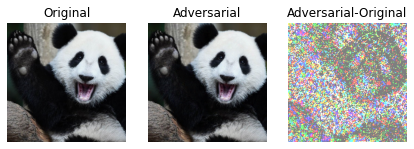

In [95]:
if result:
  adv = adv.transpose(1, 2, 0)
  adv = (adv * std) + mean
  adv = adv * 256.0
  adv = np.clip(adv, 0, 255).astype(np.uint8)
  show_images_diff(orig,adversary.original_label,adv,adversary.adversarial_label)

### EfficientNet

In [96]:
!pip install efficientnet_pytorch

In [97]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b2')

In [98]:
# Define what device we are using
logging.info("CUDA Available: {}".format(torch.cuda.is_available()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# bgr -> rgb   
orig = cv2.imread(image_path)[..., ::-1]

orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std

 
#[224,224,3]->[3,224,224]
img = img.transpose(2, 0, 1)

img = Variable(torch.from_numpy(img).to(device).float().unsqueeze(0)).cpu().numpy()


# Initialize the network

model = EfficientNet.from_name('efficientnet-b2').to(device).eval()

#print(model)


for param in model.parameters():
    param.requires_grad = False

# advbox demo
m = PytorchModel(
    model, None,(-3, 3),
    channel_axis=1)

attack = DeepFoolAttack(m)
attack_config = {"iterations": 100, "overshoot": 0.02}


inputs=img
labels = None

print(inputs.shape)

adversary = Adversary(inputs, labels)

tlabel = 538
adversary.set_target(is_targeted_attack=True, target_label=tlabel)


adversary = attack(adversary, **attack_config)


if adversary.is_successful():
    print(
        'attack success, adversarial_label=%d'
        % (adversary.adversarial_label))

    adv=adversary.adversarial_example[0]

else:
    result = False
    print('attack failed')


print("Deepfool attack done")

<ipython-input-98-b3f03defdb67>[line:2] INFO CUDA Available: False
pytorch.py[line:53] INFO Finish PytorchModel init
base.py[line:75] INFO adversary:
         original_label: 285
         target_label: 538
         is_targeted_attack: True
deepfool.py[line:41] INFO min_=-3, max_=3


cpu
(1, 3, 224, 224)


deepfool.py[line:60] INFO select label:538
deepfool.py[line:108] INFO iteration=0, f[pre_label]=0.026623930782079697, f[target_label]=-0.014727100729942322, f[adv_label]=0.026623930782079697, pre_label=285, adv_label=285
deepfool.py[line:108] INFO iteration=1, f[pre_label]=0.026623930782079697, f[target_label]=-0.014727100729942322, f[adv_label]=0.026623930782079697, pre_label=285, adv_label=285
deepfool.py[line:108] INFO iteration=2, f[pre_label]=0.026623930782079697, f[target_label]=-0.014727100729942322, f[adv_label]=0.026623930782079697, pre_label=285, adv_label=285
deepfool.py[line:108] INFO iteration=3, f[pre_label]=0.026623930782079697, f[target_label]=-0.014727100729942322, f[adv_label]=0.026623930782079697, pre_label=285, adv_label=285
deepfool.py[line:108] INFO iteration=4, f[pre_label]=0.026623930782079697, f[target_label]=-0.014727100729942322, f[adv_label]=0.026623930782079697, pre_label=285, adv_label=285
deepfool.py[line:108] INFO iteration=5, f[pre_label]=0.026623930782

attack failed
Deepfool attack done


In [99]:
if result:
  adv = adv.transpose(1, 2, 0)
  adv = (adv * std) + mean
  adv = adv * 256.0
  adv = np.clip(adv, 0, 255).astype(np.uint8)
  show_images_diff(orig,adversary.original_label,adv,adversary.adversarial_label)